In [84]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from scipy.ndimage import grey_dilation

In [3]:
#vamos aprende ler uma colecao de figuras

# Listar arquivos .png na pasta atual
current_directory = os.getcwd()+"/figuras/"
event_files = [f for f in os.listdir(current_directory) if (f.endswith('.png') and ("event" in f) and ("nue" in f))]
hit_files=[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("hit" in f) and ("nue" in f))]

event_files=sorted(event_files)
hit_files=sorted(hit_files)

In [158]:
#selecionando figuras aleatorias

n_figuras=2500
n_total=len(event_files)

random=np.random.choice(n_total,n_figuras,replace=False)

x=[]
y=[]
x_teste=[]


x_end=128#188
y_end=512#610

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(n_figuras):
    x.append(np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[random[j]]).convert('L'), dtype=np.uint8)[0:x_end,0:y_end],footprint=structure),215))
    y.append(np.divide(np.array(Image.open(current_directory+hit_files[random[j]]).convert('L'))[0:x_end,0:y_end],215))
    #y.append(x[j])

In [159]:
#deixando a saida binaria
for j in range(len(y)):
    y[j][(y[j] > 0.7)] = 1
    y[j][~((y[j] > 0.7) )] = 0 

In [160]:
#separando em treino e teste dados

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=8)
#x_train,x_test,y_train,y_test = train_test_split(x,x_teste,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)


x_train = x_train.reshape((-1, x_end,y_end, 1))
x_test = x_test.reshape((-1, x_end,y_end, 1))
y_train = y_train.reshape((-1, x_end,y_end, 1))
y_test = y_test.reshape((-1, x_end,y_end, 1))

#x=None
#y=None


In [161]:
len(x_test)

625

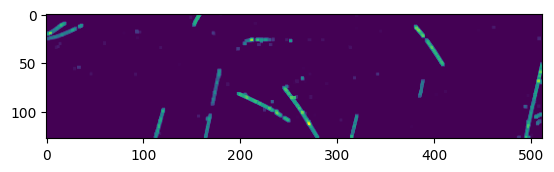

In [162]:
plt.imshow(x_train[3])

In [163]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, target_size):
        super(ResizeLayer, self).__init__()
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)

In [29]:
#preparando o modelo e compialando


encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), kernel_initializer="he_normal", padding='same', input_shape=(x_end, y_end, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same')
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)), 
    tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer="he_normal", padding='same')
])

autoencoder2 = tf.keras.Sequential([encoder, decoder])
autoencoder2.summary()


autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

/home/gabriel/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 16, 64, 256)    │       372,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 512, 1)    │     1,485,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,858,049 (7.09 MB)

 Trainable params: 1,856,257 (7.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [73]:
#apenas compila se necessario

autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [45]:
#fita
history = autoencoder2.fit(x_train,y_train, epochs=100, batch_size=10, validation_data=[x_test,y_test])

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - loss: 8.8367e-04 - val_loss: 0.0040
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - loss: 8.7339e-04 - val_loss: 0.0024
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - loss: 8.5453e-04 - val_loss: 0.0082
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 479s 3s/step - loss: 8.4664e-04 - val_loss: 0.0047
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - loss: 8.3012e-04 - val_loss: 0.0052
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - loss: 8.1697e-04 - val_loss: 0.0055
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - loss: 8.3605e-04 - val_loss: 0.0056
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - loss: 8.3043e-04 - val_loss: 0.0061
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - loss: 8.1545e-04 - val_loss: 0.0046
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - loss: 8.2690e-04 - val_loss: 0.0044


In [1]:
#printa imagem original, imagem recuperada e imagem esperada

index=15
a=autoencoder2.predict(np.expand_dims(x_test[index], axis=0))
a2=autoencoder3.predict(np.expand_dims(x_test[index], axis=0))
# Visualizar o primeiro exemplo
plt.figure(figsize=(12, 6))
# Exibir a imagem original
plt.subplot(2, 2, 1)
plt.imshow(x_test[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original Image')
plt.axis('off')  # Desliga os eixos
# Exibir a imagem reconstruída
plt.subplot(2, 2, 2)
plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Reconstructed Image')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()
# Exibir a imagem reconstruída
plt.subplot(2, 2, 3)
plt.imshow(y_test[index], cmap='gray')  # Adapte o cmap se necessário
plt.title('Original image result')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.imshow(a2[0], cmap='gray')  # Adapte o cmap se necessário
plt.title('Model 2 reconstruction')
plt.axis('off')  # Desliga os eixos
# Mostrar as imagens
plt.tight_layout()

plt.show()




NameError: name 'autoencoder2' is not defined

(array([6.5534e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.02857143, 0.05714286, 0.08571429, 0.11428571,
        0.14285714, 0.17142857, 0.2       , 0.22857143, 0.25714286,
        0.28571429, 0.31428571, 0.34285714, 0.37142857, 0.4       ,
        0.42857143, 0.45714286, 0.48571429, 0.51428571, 0.54285714,
        0.57142857, 0.6       , 0.62857143, 0.65714286, 0.68571429,
        0.71428571, 0.74285714, 0.77142857, 0.8       , 0.82857143,
        0.85714286, 0.88571429, 0.91428571, 0.94285714, 0.97142857,
        1.        ]),
 <BarContainer object of

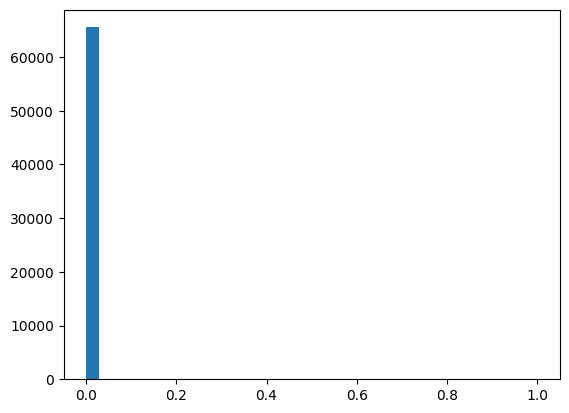

In [98]:
#histograma teste

plt.hist(y_test[index].flatten(),bins=35)

In [49]:
#da load no modelo
autoencoder2 = tf.keras.models.load_model('this_neutrino_autoencoder_5.h5')

In [128]:
#da load no modelo
autoencoder3 = tf.keras.models.load_model('this_neutrino_autoencoder_6.h5')

In [177]:
#sumario do modelo carregado
autoencoder2.summary()


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_31 (Sequential)      │ (None, 16, 64, 256)    │       372,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 128, 512, 1)    │     1,485,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,418,757 (20.67 MB)

 Trainable params: 1,780,353 (6.79 MB)

 Non-trainable params: 77,696 (303.50 KB)

 Optimizer params: 3,560,708 (13.58 MB)

In [187]:
#rdefine o que vai ser treinavel e o que nao vai ser. Layers[0] --> encoder  Layers[1]-> decoder
i=0
for layers in autoencoder2.layers[0].layers:
    layers.trainable = True #False
    if i >=10:
        layers.trainable = True #False
    i=i+1


for layers in autoencoder2.layers[1].layers:
    layers.trainable = True #False

for layers in autoencoder2.layers[0].layers:
    print(layers.trainable) 

autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    #loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [65]:
# Congelando as camadas do decoder
for layer in encoder.layers:
    layer.trainable = False


autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

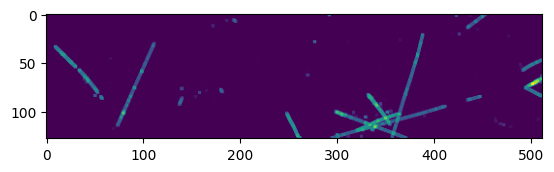

In [102]:
plt.imshow(x_train[1])

In [199]:
history = autoencoder2.fit(x_train,y_train, epochs=50, batch_size=6, validation_data=[x_test,y_test])

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 843s 3s/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 837s 3s/step - loss: 0.0010 - val_loss: 0.0015
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 835s 3s/step - loss: 9.9365e-04 - val_loss: 0.0014
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 827s 3s/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - loss: 9.9698e-04 - val_loss: 0.0012
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 843s 3s/step - loss: 9.8257e-04 - val_loss: 0.0012
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - loss: 9.6969e-04 - val_loss: 0.0015
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - loss: 9.9122e-04 - val_loss: 0.0014
Epoch 12/50
313/313 ━

In [207]:
#salva o modelo

autoencoder2.save('this_neutrino_autoencoder_primeiro_com_entropy_3.h5')

In [31]:
#carrega  pesos (mas nao esta funcionando ...)
#autoencoder2.load_weights('this_neutrino_autoencoder_4.h5')

ValueError: Shape mismatch in layer #0 (named sequential)for weight sequential/conv2d_1/kernel. Weight expects shape (3, 3, 64, 128). Received saved weight with shape (64,)

In [ ]:
#salva as imagens

x_save=None
y_save=None

n_figuras=len(event_files)
x_end=128#188
y_end=512#610

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(len(event_files)):
    x_save=np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[j]).convert('L'), dtype=np.uint8)[0:x_end,0:y_end],footprint=structure),215)
    y_save=np.divide(np.array(Image.open(current_directory+hit_files[j]).convert('L'))[0:x_end,0:y_end],215)
    
    x_save=np.array(x_save)
    x_save = x_save.reshape((-1, x_end,y_end, 1))

    y_save=np.array(y_save)
    y_save = y_save.reshape((-1, x_end,y_end, 1))

    filename=os.path.splitext(event_files[j])[0]
    a=autoencoder2.predict(x_save)
    # Visualizar o primeiro exemplo
    plt.figure(figsize=(12, 6))
    # Exibir a imagem original
    plt.subplot(2, 2, 1)
    plt.imshow(x_save[0,:], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Original Image')
    plt.axis('off')  # Desliga os eixos
    # Exibir a imagem reconstruída
    plt.subplot(2, 2, 2)
    plt.imshow(a[0], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Reconstructed Image')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()
    # Exibir a imagem reconstruída
    plt.subplot(2, 2, 3)
    plt.imshow(y_save[0,:], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Original image result')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()
    plt.savefig(f"./results/"+filename+".png",  bbox_inches='tight', pad_inches=0)
    plt.clf()  # Limpa a figura para a próxima imagem
                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


/tmp/ipykernel_469236/3855929787.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#nao preciso trocar a ultima camada na verdade, quero trocar a funcao erro para binary entropy. Mas para isso preciso fazer as imagens serem ou 0 ou 1